# **Understanding the Data**
We will first import all the necessary libraries and modules:



In [31]:
import pandas as pd
import numpy as np
import networkx as nx
import random
import math
import csv
import datetime
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
import lightgbm as lgbm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

import multiprocessing as mp

Let’s now create a dataframe of all the nodes. Every row of this dataframe represents a link formed by the nodes in the columns ‘node_1’ and ‘node_2’, respectively:

In [2]:
def create_dataframe_from_file(filename):
    # Read the text file
    with open(filename, 'r') as file:
        lines = file.readlines()

    # Extract the node pairs from each line
    data = [list(map(int, line.strip().split())) for line in lines]

    # Create the DataFrame
    df = pd.DataFrame(data, columns=['node 1', 'node 2'])
    return df

filename = '/content/drive/MyDrive/Colab Notebooks/complex_network/facebook_combined.txt'
df = create_dataframe_from_file(filename)
df

,node 1,node 2
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5
...,...,...
88229,4026,4030
88230,4027,4031
88231,4027,4032
88232,4027,4038


We can easily represent this arrangement of Facebook pages in the form of a graph:

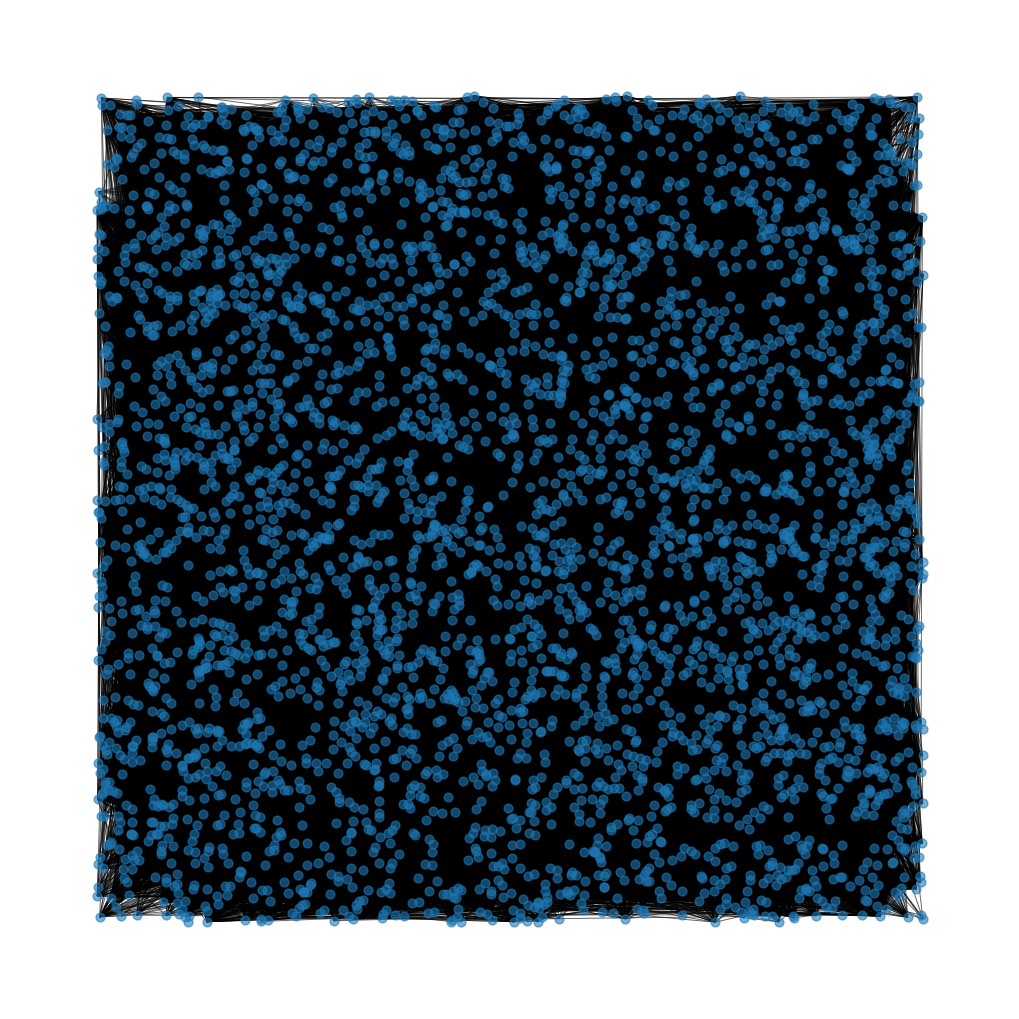

In [3]:
# create graph
G = nx.from_pandas_edgelist(df, "node 1", "node 2", create_using=nx.Graph())

# plot graph
plt.figure(figsize=(10,10))

pos = nx.random_layout(G, seed=23)
nx.draw(G, with_labels=False,  pos = pos, node_size = 40, alpha = 0.6, width = 0.7)

plt.show()

his is what we are going to deal with – a wire mesh of Facebook pages (blue dots). The black lines are the links or edges connecting all the nodes to each other.

# **Dataset Preparation for Model Building**
> We need to prepare the dataset from an undirected graph. This dataset will have features of node pairs and the target variable would be binary in nature, indicating the presence of links (or not).

  - Retrieve Unconnected Node Pairs – `Negative Samples`
  >We have already understood that to solve a link prediction problem, we have to prepare a dataset from the given graph. A major part of this dataset is the negative samples or the unconnected node pairs

  - Remove Links from Connected Node Pairs – `Positive Samples`
  >we will randomly drop some of the edges from the graph. However, randomly removing edges may result in cutting off loosely connected nodes and fragments of the graph. This is something that we have to take care of.

In [4]:
def create_graph_from_file(filename):
    f = open(filename, "rb")
    g = nx.read_edgelist(f)
    return g

In [5]:
def sample_extraction(g, pos_num, neg_num, neg_mode, neg_distance=2, delete=1):

    print("----------------extract positive samples--------------------")
    # randomly select pos_num as test edges
    pos_sample = random.sample(g.edges(), pos_num)
    sample_g = nx.Graph()
    sample_g.add_edges_from(pos_sample, positive="True")
    nx.write_edgelist(sample_g, "sample_positive_" +str(pos_num)+ ".txt", data=['positive'])

    # adding non-existing edges
    print("----------------extract negative samples--------------------")
    i = 0
    neg_g = nx.Graph()
    produce_fake_edge(g,neg_g,neg_num)
    nx.write_edgelist(neg_g, "sample_negative_" +str(neg_num)+ ".txt", data=["positive"])
    neg_sample = neg_g.edges()
    neg_g.add_edges_from(pos_sample,positive="True")
    nx.write_edgelist(neg_g, "sample_combine_" +str(pos_num + neg_num)+ ".txt", data=["positive"])

    # remove the positive sample edges, the rest is the training set
    if delete == 0:
        return pos_sample, neg_sample
    else:
        g.remove_edges_from(pos_sample)
        nx.write_edgelist(g, "training.txt", data=False)

        return pos_sample, neg_sample

In [6]:
def produce_fake_edge(g, neg_g,num_test_edges):
    i = 0
    while i < num_test_edges:
        edge = random.sample(g.nodes(), 2)
        try:
            shortest_path = nx.shortest_path_length(g,source=edge[0],target=edge[1])
            if shortest_path >= 2:
                neg_g.add_edge(edge[0],edge[1], positive="False")
                i += 1
        except:
            pass

In [7]:
filename="/content/drive/MyDrive/Colab Notebooks/complex_network/facebook_combined.txt";
g = create_graph_from_file(filename)
num_edges = g.number_of_edges()

pos_num = 0.1
neg_num = 0.1
pos_num = int(num_edges * pos_num)
neg_num = int(num_edges * neg_num)

neg_mode="easy"
pos_sample, neg_sample = sample_extraction(g, pos_num, neg_num,neg_mode)

----------------extract positive samples--------------------
----------------extract negative samples--------------------


<ipython-input-5-c9fef63a3ee3>:5: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  pos_sample = random.sample(g.edges(), pos_num)
<ipython-input-6-c4246691acef>:4: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  edge = random.sample(g.nodes(), 2)


In [8]:
pos_sample

[('2757', '3036'),
 ('2147', '2218'),
 ('2299', '2423'),
 ('1964', '2126'),
 ('3120', '3146'),
 ('1159', '1227'),
 ('439', '527'),
 ('2886', '2949'),
 ('4026', '4030'),
 ('2164', '2271'),
 ('1936', '2388'),
 ('1584', '1761'),
 ('2333', '2003'),
 ('1352', '1612'),
 ('3804', '3838'),
 ('1359', '1608'),
 ('2694', '2912'),
 ('2782', '3184'),
 ('1107', '1289'),
 ('3534', '3758'),
 ('2590', '2600'),
 ('1229', '1578'),
 ('2149', '2194'),
 ('934', '980'),
 ('2102', '2153'),
 ('2128', '2344'),
 ('2399', '2608'),
 ('3272', '3351'),
 ('1465', '2543'),
 ('1963', '2604'),
 ('1256', '1288'),
 ('2719', '2828'),
 ('2112', '2546'),
 ('2347', '2485'),
 ('2480', '2610'),
 ('2218', '2619'),
 ('1963', '2154'),
 ('3660', '3775'),
 ('2806', '3430'),
 ('3335', '3419'),
 ('2302', '2436'),
 ('2103', '2563'),
 ('2729', '3080'),
 ('2550', '2622'),
 ('927', '1182'),
 ('2244', '2655'),
 ('963', '1118'),
 ('2040', '2354'),
 ('1330', '1811'),
 ('916', '1861'),
 ('1426', '1790'),
 ('1932', '2149'),
 ('2233', '2591'),


In [9]:
neg_sample

EdgeView([('1834', '2649'), ('1834', '2218'), ('1834', '2416'), ('1834', '2824'), ('1834', '466'), ('2649', '2480'), ('2649', '434'), ('2649', '2339'), ('2649', '2605'), ('2649', '2417'), ('2649', '1945'), ('2649', '2187'), ('2649', '2471'), ('2649', '2283'), ('2649', '2445'), ('2649', '1718'), ('2649', '2279'), ('4009', '2739'), ('4009', '478'), ('4009', '139'), ('4009', '995'), ('4009', '1233'), ('4009', '173'), ('4009', '3968'), ('4009', '2654'), ('4009', '2266'), ('4009', '3665'), ('4009', '4023'), ('2739', '924'), ('2739', '3349'), ('2739', '3008'), ('2739', '806'), ('2739', '1541'), ('2739', '2730'), ('2739', '3168'), ('2818', '3827'), ('2818', '995'), ('2818', '527'), ('2818', '3909'), ('2818', '3548'), ('2818', '959'), ('2818', '2833'), ('2818', '3234'), ('2818', '1517'), ('2818', '2813'), ('2818', '3353'), ('2818', '3350'), ('3827', '3915'), ('3827', '1012'), ('3827', '137'), ('3827', '3521'), ('2539', '3983'), ('2539', '3986'), ('2539', '2413'), ('2539', '3817'), ('2539', '24

# **Feature Extraction**
https://www.mdpi.com/2504-4990/2/4/36

Following Scoring Methods are used to construct feature Set

- `common_neighbors`


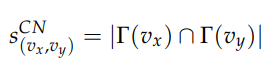
- `resource_allocation_index`


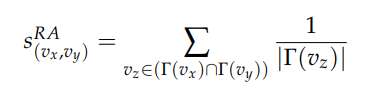
- `jaccard_coefficient`


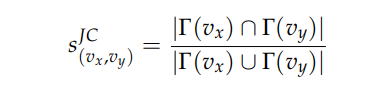

- `adamic_adar_index`


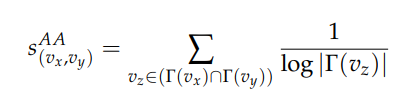
- `preferential_attachment`


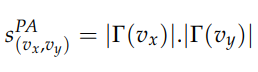

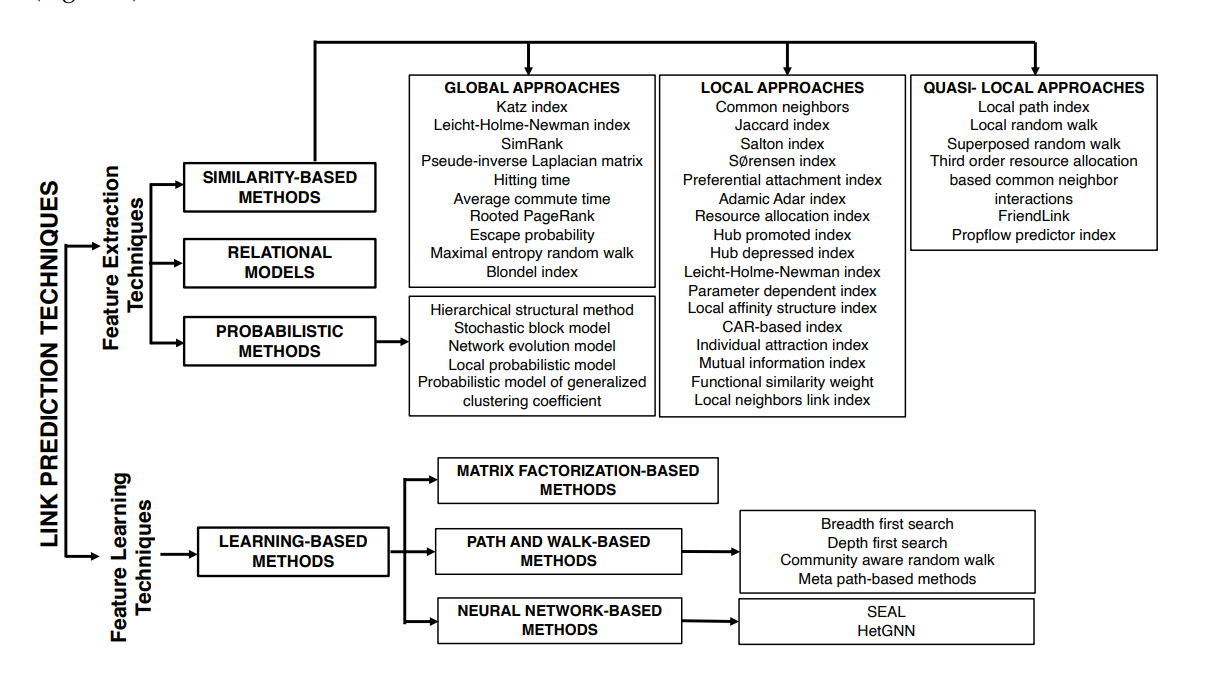

In [10]:
def CommonNeighbors(u, v, g):
    u_neighbors = set(g.neighbors(u))
    v_neighbors = set(g.neighbors(v))
    return len(u_neighbors.intersection(v_neighbors))

In [11]:
def common_neighbors(g, edges):
    result = []
    for edge in edges:
        node_one, node_two = edge[0], edge[1]
        num_common_neighbors = 0
        try:
            neighbors_one, neighbors_two = g.neighbors(node_one), g.neighbors(node_two)
            for neighbor in neighbors_one:
                if neighbor in neighbors_two:
                    num_common_neighbors += 1
            result.append((node_one, node_two, num_common_neighbors))
        except:
            pass
    return result

In [12]:
def AdamicAdar(u, v, g):
    u_neighbors = set(g.neighbors(u))
    v_neighbors = set(g.neighbors(v))
    aa = 0
    for i in u_neighbors.intersection(v_neighbors):
        aa += 1 / math.log(len(g.neighbors(i)))
    return aa

In [13]:
def ResourceAllocation(u, v, g):
    u_neighbors = set(g.neighbors(u))
    v_neighbors = set(g.neighbors(v))
    ra = 0
    for i in u_neighbors.intersection(v_neighbors):
        ra += 1 / float(len(g.neighbors(i)))
    return ra

In [14]:
def JaccardCoefficent(u, v, g):
    u_neighbors = set(g.neighbors(u))
    v_neighbors = set(g.neighbors(v))
    return len(u_neighbors.intersection(v_neighbors)) / float(len(u_neighbors.union(v_neighbors)))

In [15]:
def PreferentialAttachment(u, v, g):
    return len(g.neighbors(u))*len(g.neighbors(v))

In [16]:
def AllFeatures(u,v,g1, g2):
    try:
        cn = CommonNeighbors(u, v, g2)
        aa = AdamicAdar(u, v, g2)
        ra = ResourceAllocation(u, v, g2)
        jc = JaccardCoefficent(u, v, g2)
        pa = PreferentialAttachment(u, v, g2)

        delta_cn = cn - CommonNeighbors(u, v, g1)
        delta_aa = aa - AdamicAdar(u, v, g1)
        delta_ra = ra - ResourceAllocation(u, v, g1)
        delta_jc = jc - JaccardCoefficent(u, v, g1)
        delta_pa = pa - PreferentialAttachment(u, v, g1)
        return {"cn":cn, "aa": aa, "ra":ra, "jc":jc, "pa":pa,
            "delta_cn": delta_cn, "delta_aa": delta_aa, "delta_ra": delta_ra,
             "delta_jc": delta_jc, "delta_pa": delta_pa}
    except:
        pass

In [17]:
def feature_extraction(g, pos_sample, neg_sample, feature_name, model="single", combine_num=5):

    data = []
    if model == "single":
        preds = feature_name(g, pos_sample)
        feature = [feature_name.__name__] + [i[2] for i in preds]
        label = ["label"] + ["1" for i in range(len(feature))]
        preds = feature_name(g, neg_sample)
        feature1 = [i[2] for i in preds]
        feature = feature + feature1
        label = label + ["0" for i in range(len(feature1))]
        data = [feature, label]
        data = transpose(data)
        write_data_to_file(data, "features_" + model + "_" + feature_name.__name__ + ".csv")
    else:
        label = ["label"] + ["1" for i in range(len(pos_sample))] + ["0" for i in range(len(neg_sample))]
        for j in feature_name:
            preds = j(g, pos_sample)

            feature = [j.__name__] + [i[2] for i in preds]
            preds = j(g, neg_sample)
            feature = feature + [i[2] for i in preds]
            data.append(feature)

        data.append(label)
        data = transpose(data)
        write_data_to_file(data, "features_" + model + "_" + str(combine_num) + ".csv")
    return data

In [18]:
def write_data_to_file(data, filename):
    csvfile = open(filename, "w")
    writer = csv.writer(csvfile)
    for i in data:
        writer.writerow(i)
    csvfile.close()

In [19]:
def transpose(data):
    return [list(i) for i in zip(*data)]

In [20]:
feature_set = [common_neighbors, nx.resource_allocation_index, nx.jaccard_coefficient, nx.adamic_adar_index, nx.preferential_attachment]
combine_num = 1
model="combined"

train_data = feature_extraction(g, pos_sample, neg_sample, feature_set, model, combine_num)

train_data_df = pd.DataFrame(train_data, columns = train_data[0])
train_data_df.head()

,common_neighbors,resource_allocation_index,jaccard_coefficient,adamic_adar_index,preferential_attachment,label
0,common_neighbors,resource_allocation_index,jaccard_coefficient,adamic_adar_index,preferential_attachment,label
1,1,0.163543,0.136842,2.918885,2516,1
2,3,0.14645,0.094059,3.843732,6358,1
3,3,0.672195,0.554348,20.246217,20349,1
4,1,0.579005,0.157025,5.293535,4416,1


# **Building our Link Prediction Model**
To validate the performance of our model, we should split our data into two parts – one for training the model and the other to test the model’s performance:

### 1- evaluate models with combined features

In [32]:
cn = 1
r=np.loadtxt(open("features_combined_"+str(cn)+".csv", "rb"), delimiter=",", skiprows=1);

In [33]:
l,b=r.shape;

In [34]:
np.random.shuffle(r);

In [35]:
train_l=int(0.75*l)
X_train=r[0:train_l,0:b-1]
Y_train=r[0:train_l,b-1]
X_test=r[train_l:l,0:b-1]
Y_test=r[train_l:l,b-1]
X_train = normalize(X_train, axis=0, norm='max')
X_test = normalize(X_test, axis=0, norm='max')
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [38]:
def Svm(training, training_labels, testing, testing_labels):
    start = datetime.datetime.now()
    clf = svm.SVC()
    clf.fit(training, training_labels)
    result = clf.predict(testing)

    precision = precision_score(testing_labels, result)
    recall = recall_score(testing_labels, result)

    print("SVM accuracy:", accuracy_score(testing_labels, result))
    print("SVM precision:", precision)
    print("SVM recall:", recall)
    print("SVM F1 score:", f1_score(testing_labels, result))

In [39]:
Svm(X_train,Y_train,X_test,Y_test)

SVM accuracy: 0.6738210399032648
SVM precision: 0.5355997434252726
SVM recall: 0.36800352578228296
SVM F1 score: 0.4362591431556949


In [42]:
def logistic_regression(training, training_labels, testing, testing_labels):
    clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='ovr').fit(training, training_labels)
    clf.fit(training, training_labels)
    result=clf.predict(testing)

    precision = precision_score(testing_labels, result)
    recall = recall_score(testing_labels, result)

    print("Linear accuracy:", accuracy_score(testing_labels, result))
    print("Linear precision:", precision)
    print("Linear recall:", recall)
    print("Linear F1 score:", f1_score(testing_labels, result))

In [43]:
logistic_regression(X_train,Y_train,X_test,Y_test)

Linear accuracy: 0.6695888754534461
Linear precision: 0.5123622281799225
Linear recall: 0.7580431908329661
Linear F1 score: 0.6114468538926413


In [44]:
def ANN(training, training_labels, testing, testing_labels):
    clf = MLPClassifier(solver='adam', alpha=1e-5,hidden_layer_sizes=(15,9), random_state=1)
    clf.fit(training, training_labels)
    result = clf.predict(testing)

    precision = precision_score(testing_labels, result)
    recall = recall_score(testing_labels, result)

    print("ANN accuracy:", accuracy_score(testing_labels, result))
    print("ANN precision:", precision)
    print("ANN recall:", recall)
    print("ANN F1 score:", f1_score(testing_labels, result))


In [45]:
ANN(X_train,Y_train,X_test,Y_test)

ANN accuracy: 0.6697400241837969
ANN precision: 0.5434782608695652
ANN recall: 0.23137946231820186
ANN F1 score: 0.32457496136012365


In [ ]:
def lightgbm(training, training_labels, testing, testing_labels):
    train_data = lgbm.Dataset(training, training_labels)
    gbm = lgbm.train(parameters,
                     train_data,
                     num_boost_round=10
                     )

    y_pred = gbm.predict(testing)
    accuracy = accuracy_score(testing_labels, (y_pred > 0.5).astype(int))
    roc_auc = roc_auc_score(testing_labels, y_pred)
    print(f'lgbm Accuracy: {accuracy}')
    print(f'lgbm ROC AUC: {roc_auc}')

In [ ]:
# Define parameters
parameters = {
    'objective': 'binary',
    'is_unbalance': 'true',
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'num_threads': 2,
    'seed': 76,
}

lightgbm(X_train,Y_train,X_test,Y_test)

[LightGBM] [Info] Number of positive: 6624, number of negative: 13225
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1050
[LightGBM] [Info] Number of data points in the train set: 19849, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333720 -> initscore=-0.691410
[LightGBM] [Info] Start training from score -0.691410
lgbm Accuracy: 0.6870182862324317
lgbm ROC AUC: 0.7698998845312419


In [47]:
def xgboost(training, training_labels, testing, testing_labels):
    bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')
    bst.fit(training, training_labels)
    result = bst.predict(testing)

    precision = precision_score(testing_labels, result)
    recall = recall_score(testing_labels, result)

    print("XGBoost accuracy:", accuracy_score(testing_labels, result))
    print("XGBoost precision:", precision)
    print("XGBoost recall:", recall)
    print("XGBoost F1 score:", f1_score(testing_labels, result))

In [48]:
xgboost(X_train,Y_train,X_test,Y_test)

XGBoost accuracy: 0.6735187424425635
XGBoost precision: 0.5478489903424056
XGBoost recall: 0.2750110180696342
XGBoost F1 score: 0.36619718309859156


In [53]:
def random_forest(training, training_labels, testing, testing_labels):
    clf = RandomForestClassifier(random_state=0)
    clf.fit(training, training_labels)
    result = clf.predict(testing)


    precision = precision_score(testing_labels, result)
    recall = recall_score(testing_labels, result)

    print("Random Forest accuracy:", accuracy_score(testing_labels, result))
    print("Random Forest precision:", precision)
    print("Random Forest recall:", recall)
    print("Random Forest F1 score:", f1_score(testing_labels, result))


In [54]:
random_forest(X_train,Y_train,X_test,Y_test)

Random Forest accuracy: 0.6605199516324063
Random Forest precision: 0.5071830106183636
Random Forest recall: 0.35786690171881885
Random Forest F1 score: 0.4196382428940568


In [59]:
def knn(training, training_labels, testing, testing_labels, n_neighbors=5):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(training, training_labels)
    result = knn.predict(testing)

    precision = precision_score(testing_labels, result)
    recall = recall_score(testing_labels, result)

    print("KNN accuracy:", accuracy_score(testing_labels, result))
    print("KNN precision:", precision)
    print("KNN recall:", recall)
    print("KNN F1 score:", f1_score(testing_labels, result))


In [60]:
knn(X_train,Y_train,X_test,Y_test)

KNN accuracy: 0.6692865779927448
KNN precision: 0.5190947666195191
KNN recall: 0.48523578669017187
KNN F1 score: 0.5015945330296129


### 2- evaluate models with just jaccard_coefficient feature extraction

In [61]:
feature_set = nx.jaccard_coefficient
combine_num = 1
model="single"


train_data2 = feature_extraction(g, pos_sample, neg_sample, feature_set, model, combine_num)

train_data_df2 = pd.DataFrame(train_data, columns = train_data[0])
train_data_df2.head()

,common_neighbors,resource_allocation_index,jaccard_coefficient,adamic_adar_index,preferential_attachment,label
0,common_neighbors,resource_allocation_index,jaccard_coefficient,adamic_adar_index,preferential_attachment,label
1,1,0.163543,0.136842,2.918885,2516,1
2,3,0.14645,0.094059,3.843732,6358,1
3,3,0.672195,0.554348,20.246217,20349,1
4,1,0.579005,0.157025,5.293535,4416,1


In [62]:
r=np.loadtxt(open("features_single_jaccard_coefficient"+".csv", "rb"), delimiter=",", skiprows=1);
l,b=r.shape;
np.random.shuffle(r);

In [63]:
train_l=int(0.75*l)
X_train=r[0:train_l,0:b-1]
Y_train=r[0:train_l,b-1]
X_test=r[train_l:l,0:b-1]
Y_test=r[train_l:l,b-1]
X_train = normalize(X_train, axis=0, norm='max')
X_test = normalize(X_test, axis=0, norm='max')
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [64]:
Svm(X_train,Y_train,X_test,Y_test)

SVM accuracy: 0.652962515114873
SVM precision: 0.47806774014436426
SVM recall: 0.38836265223274696
SVM F1 score: 0.4285714285714286


In [65]:
logistic_regression(X_train,Y_train,X_test,Y_test)

Linear accuracy: 0.6692865779927448
Linear precision: 0.5116092874299439
Linear recall: 0.2882273342354533
Linear F1 score: 0.36872475476053085


In [66]:
ANN(X_train,Y_train,X_test,Y_test)

ANN accuracy: 0.6535671100362757
ANN precision: 0.4836316019205587
ANN recall: 0.4997744700045106
ANN F1 score: 0.4915705412599823


In [67]:
xgboost(X_train,Y_train,X_test,Y_test)

XGBoost accuracy: 0.6649032648125756
XGBoost precision: 0.0
XGBoost recall: 0.0
XGBoost F1 score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [68]:
random_forest(X_train,Y_train,X_test,Y_test)

Random Forest accuracy: 0.4830713422007255
Random Forest precision: 0.223193741371376
Random Forest recall: 0.21876409562471807
Random Forest F1 score: 0.22095671981776768


In [69]:
knn(X_train,Y_train,X_test,Y_test)

KNN accuracy: 0.5399032648125756
KNN precision: 0.3066853669939224
KNN recall: 0.29589535408209294
KNN F1 score: 0.3011937557392103


### 3- evaluate models with just common_neighbors feature extraction

In [70]:
feature_set = common_neighbors
combine_num = 1
model="single"


train_data = feature_extraction(g, pos_sample, neg_sample, feature_set, model, combine_num)

train_data_df = pd.DataFrame(train_data, columns = train_data[0])
train_data_df.head()

,common_neighbors,label
0,common_neighbors,label
1,1,1
2,3,1
3,3,1
4,1,1


In [71]:
r=np.loadtxt(open("features_single_common_neighbors.csv", "rb"), delimiter=",", skiprows=1);

In [72]:
train_l=int(0.75*l)
X_train=r[0:train_l,0:b-1]
Y_train=r[0:train_l,b-1]
X_test=r[train_l:l,0:b-1]
Y_test=r[train_l:l,b-1]
X_train = normalize(X_train, axis=0, norm='max')
X_test = normalize(X_test, axis=0, norm='max')
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [73]:
Svm(X_train,Y_train,X_test,Y_test)

SVM accuracy: 0.5323458282950423
SVM precision: 0.0
SVM recall: 0.0
SVM F1 score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [74]:
logistic_regression(X_train,Y_train,X_test,Y_test)

Linear accuracy: 0.7758464328899637
Linear precision: 0.0
Linear recall: 0.0
Linear F1 score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [75]:
ANN(X_train,Y_train,X_test,Y_test)

ANN accuracy: 0.5323458282950423
ANN precision: 0.0
ANN recall: 0.0
ANN F1 score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [76]:
xgboost(X_train,Y_train,X_test,Y_test)

XGBoost accuracy: 0.5323458282950423
XGBoost precision: 0.0
XGBoost recall: 0.0
XGBoost F1 score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [77]:
random_forest(X_train,Y_train,X_test,Y_test)

Random Forest accuracy: 0.5368802902055623
Random Forest precision: 0.0
Random Forest recall: 0.0
Random Forest F1 score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [78]:
knn(X_train,Y_train,X_test,Y_test)

KNN accuracy: 0.1292321644498186
KNN precision: 0.0
KNN recall: 0.0
KNN F1 score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 4- evaluate models with just adamic_adar_index: feature extraction

In [79]:
feature_set = nx.adamic_adar_index
combine_num = 1
model="single"


train_data = feature_extraction(g, pos_sample, neg_sample, feature_set, model, combine_num)

train_data_df = pd.DataFrame(train_data, columns = train_data[0])
train_data_df.head()

,adamic_adar_index,label
0,adamic_adar_index,label
1,2.918885,1
2,3.843732,1
3,20.246217,1
4,5.293535,1


In [80]:
r=np.loadtxt(open("features_single_adamic_adar_index.csv", "rb"), delimiter=",", skiprows=1);

In [81]:
train_l=int(0.75*l)
X_train=r[0:train_l,0:b-1]
Y_train=r[0:train_l,b-1]
X_test=r[train_l:l,0:b-1]
Y_test=r[train_l:l,b-1]
X_train = normalize(X_train, axis=0, norm='max')
X_test = normalize(X_test, axis=0, norm='max')
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [82]:
Svm(X_train,Y_train,X_test,Y_test)

SVM accuracy: 0.49138452237001207
SVM precision: 0.0
SVM recall: 0.0
SVM F1 score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [83]:
logistic_regression(X_train,Y_train,X_test,Y_test)

Linear accuracy: 0.7366989117291415
Linear precision: 0.0
Linear recall: 0.0
Linear F1 score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [84]:
ANN(X_train,Y_train,X_test,Y_test)

ANN accuracy: 0.46402660217654174
ANN precision: 0.0
ANN recall: 0.0
ANN F1 score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [85]:
xgboost(X_train,Y_train,X_test,Y_test)

XGBoost accuracy: 0.46130592503022977
XGBoost precision: 0.0
XGBoost recall: 0.0
XGBoost F1 score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [86]:
random_forest(X_train,Y_train,X_test,Y_test)

Random Forest accuracy: 0.5817714631197098
Random Forest precision: 0.0
Random Forest recall: 0.0
Random Forest F1 score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [87]:
knn(X_train,Y_train,X_test,Y_test)

KNN accuracy: 0.10822249093107618
KNN precision: 0.0
KNN recall: 0.0
KNN F1 score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 5- evaluate models with just resource_allocation_index feature extraction

In [88]:
feature_set = nx.resource_allocation_index
combine_num = 1
model="single"


train_data = feature_extraction(g, pos_sample, neg_sample, feature_set, model, combine_num)

train_data_df = pd.DataFrame(train_data, columns = train_data[0])
train_data_df.head()

,resource_allocation_index,label
0,resource_allocation_index,label
1,0.163543,1
2,0.14645,1
3,0.672195,1
4,0.579005,1


In [89]:
r=np.loadtxt(open("features_single_resource_allocation_index.csv", "rb"), delimiter=",", skiprows=1);

In [90]:
train_l=int(0.75*l)
X_train=r[0:train_l,0:b-1]
Y_train=r[0:train_l,b-1]
X_test=r[train_l:l,0:b-1]
Y_test=r[train_l:l,b-1]
X_train = normalize(X_train, axis=0, norm='max')
X_test = normalize(X_test, axis=0, norm='max')
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [91]:
Svm(X_train,Y_train,X_test,Y_test)

SVM accuracy: 0.4823155985489722
SVM precision: 0.0
SVM recall: 0.0
SVM F1 score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [92]:
logistic_regression(X_train,Y_train,X_test,Y_test)

Linear accuracy: 0.7043530834340992
Linear precision: 0.0
Linear recall: 0.0
Linear F1 score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [93]:
ANN(X_train,Y_train,X_test,Y_test)

ANN accuracy: 0.4779322853688029
ANN precision: 0.0
ANN recall: 0.0
ANN F1 score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [94]:
xgboost(X_train,Y_train,X_test,Y_test)

XGBoost accuracy: 0.4817110036275695
XGBoost precision: 0.0
XGBoost recall: 0.0
XGBoost F1 score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [95]:
random_forest(X_train,Y_train,X_test,Y_test)

Random Forest accuracy: 0.4718863361547763
Random Forest precision: 0.0
Random Forest recall: 0.0
Random Forest F1 score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [96]:
knn(X_train,Y_train,X_test,Y_test)

KNN accuracy: 0.01919588875453446
KNN precision: 0.0
KNN recall: 0.0
KNN F1 score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 6- evaluate models with just preferential_attachment feature extraction

In [97]:
feature_set = nx.preferential_attachment
combine_num = 1
model="single"


train_data = feature_extraction(g, pos_sample, neg_sample, feature_set, model, combine_num)

train_data_df = pd.DataFrame(train_data, columns = train_data[0])
train_data_df.head()

,preferential_attachment,label
0,preferential_attachment,label
1,2516,1
2,6358,1
3,20349,1
4,4416,1


In [98]:
r=np.loadtxt(open("features_single_preferential_attachment.csv", "rb"), delimiter=",", skiprows=1);

In [99]:
train_l=int(0.75*l)
X_train=r[0:train_l,0:b-1]
Y_train=r[0:train_l,b-1]
X_test=r[train_l:l,0:b-1]
Y_test=r[train_l:l,b-1]
X_train = normalize(X_train, axis=0, norm='max')
X_test = normalize(X_test, axis=0, norm='max')
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [100]:
Svm(X_train,Y_train,X_test,Y_test)

SVM accuracy: 0.5922007255139057
SVM precision: 0.0
SVM recall: 0.0
SVM F1 score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [101]:
logistic_regression(X_train,Y_train,X_test,Y_test)

Linear accuracy: 0.7076783555018138
Linear precision: 0.0
Linear recall: 0.0
Linear F1 score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [102]:
ANN(X_train,Y_train,X_test,Y_test)

ANN accuracy: 0.5143591293833132
ANN precision: 0.0
ANN recall: 0.0
ANN F1 score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [103]:
xgboost(X_train,Y_train,X_test,Y_test)

XGBoost accuracy: 0.5976420798065296
XGBoost precision: 0.0
XGBoost recall: 0.0
XGBoost F1 score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [104]:
random_forest(X_train,Y_train,X_test,Y_test)

Random Forest accuracy: 0.5885731559854898
Random Forest precision: 0.0
Random Forest recall: 0.0
Random Forest F1 score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [105]:
knn(X_train,Y_train,X_test,Y_test)

KNN accuracy: 0.4584340991535671
KNN precision: 0.0
KNN recall: 0.0
KNN F1 score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


>The conclusion is that when I used a combination of feature extraction methods better results were obtained in all metrics.
Then using only the jaccard coefficient feature had better results.

---

